## 9/11

Veamos qué sucede si entrenamos datos antes del 9/11 y testeamos luego y antes de tal evento 

In [1]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch
import numpy as np
import math
import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)

# load data
tmp_dir = "./tmp_csv/"


Entrenamos con datos de hasta un mes antes del atentado y comparamos:
* error en el último mes antes del evento
* error en el primer mes después del evento

In [105]:
df = pd.read_csv(tmp_dir+"daily/full.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

train_limit = 2001 
nine_eleven_event = pd.to_datetime("2001-9-11")

year_before = nine_eleven_event - pd.offsets.DateOffset(years=1)
year_after = nine_eleven_event + pd.offsets.DateOffset(years=1)

days_before_nine_eleven = len(df.loc[df["date"].dt.date < nine_eleven_event])
days_after_nine_eleven = len(df.loc[df["date"].dt.date < year_after])

train_delays = df.loc[df["date"].dt.date < year_before]["ArrDelay"]
print(len(train_delays))
print(len(df["ArrDelay"]))
print(df.loc[df["date"].dt.date < year_before])

2445
5479
           date   ArrDelay
0    1994-01-01   1.777870
1    1994-01-02   7.971149
2    1994-01-03  11.952367
3    1994-01-04  14.939042
4    1994-01-05  16.644046
...         ...        ...
2440 2000-09-06   3.484375
2441 2000-09-07   3.842283
2442 2000-09-08   5.114179
2443 2000-09-09  -0.293148
2444 2000-09-10  11.004608

[2445 rows x 2 columns]


In [106]:
max_grade = 1
phases = [i*math.pi/2 for i in range(4)]
monthly_freqs =  [3, 4, 6, 12]
# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
daily_freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]] 

class lsqPredictor:
    def __init__(self, phases, freqs, max_grade):
        self.phases = phases
        self.freqs = freqs
        self.max_grade = max_grade
    
    def trig_vals(self, t):
        return  [math.sin(2 * math.pi / f * t + p) for f in self.freqs for p in self.phases]

    def get_x_vals(self, x):
        x_vals = []
        for i in range(len(x)):
            row = np.array([i**p for p in range(self.max_grade+1)] + self.trig_vals(i), dtype='float')
            x_vals.append(row)
        return x_vals
    
    def print_coefs(self):
        c = 0
        for i in range(self.max_grade+1):
            print("Coef de x^{}:\n{}".format(i, self.coefs[c]))
            c += 1
        for i in self.freqs:
            for j in self.phases:
                print("Coef de sinusoide con frecuencia {} y fase {}:\n{}".format(i, j, self.coefs[c]))
                c += 1
                
    def fit(self, train_set):
        arrays = self.get_x_vals(train_set)
        A = np.stack(arrays)
        self.coefs = np.linalg.solve(A.T@A, A.T@train_set)
    
    def pred(self, pred_set):
        arrays = self.get_x_vals(pred_set)
        full_A = np.stack(arrays)        
        return full_A@self.coefs 
    
lpr = lsqPredictor(phases, daily_freqs, max_grade)
lpr.fit(train_delays)
lpr.print_coefs()

Coef de x^0:
6.303303631548324
Coef de x^1:
0.00130509312562392
Coef de sinusoide con frecuencia 7 y fase 0.0:
-441.02940863476164
Coef de sinusoide con frecuencia 7 y fase 1.5707963267948966:
99507.33287583124
Coef de sinusoide con frecuencia 7 y fase 3.141592653589793:
-439.2910590462475
Coef de sinusoide con frecuencia 7 y fase 4.71238898038469:
99507.59740573747
Coef de sinusoide con frecuencia 29.583333333333332 y fase 0.0:
-1984.9813111011147
Coef de sinusoide con frecuencia 29.583333333333332 y fase 1.5707963267948966:
-734.4322975212733
Coef de sinusoide con frecuencia 29.583333333333332 y fase 3.141592653589793:
-1984.3513364497185
Coef de sinusoide con frecuencia 29.583333333333332 y fase 4.71238898038469:
-734.4466019417475
Coef de sinusoide con frecuencia 59.166666666666664 y fase 0.0:
-2370.0885734811386
Coef de sinusoide con frecuencia 59.166666666666664 y fase 1.5707963267948966:
229.97509922005065
Coef de sinusoide con frecuencia 59.166666666666664 y fase 3.141592653589

In [107]:
if "dl_pred" in df:
    del df["dl_pred"]

In [108]:
train_test_delays = df["ArrDelay"]

df["dl_pred"] = lpr.pred(train_test_delays) 
df.describe()

,ArrDelay,dl_pred
count,5479.000000,5479.000000
mean,7.241327,9.885768
std,7.327431,2.932719
min,-19.000000,1.901272
25%,2.095552,7.789136
50%,5.977256,9.858978
75%,10.878614,11.935438
max,67.904927,18.124018


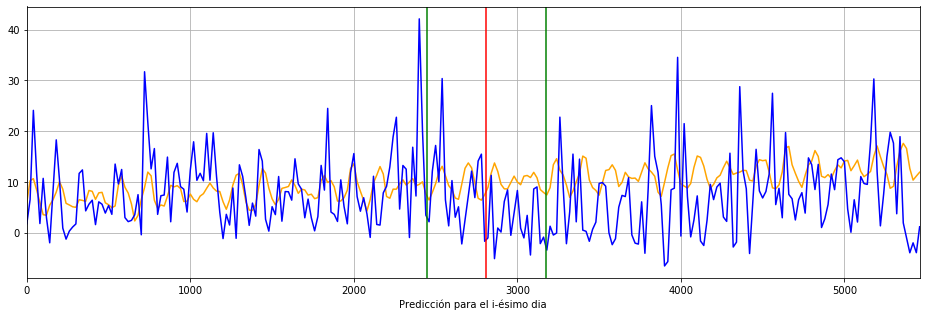

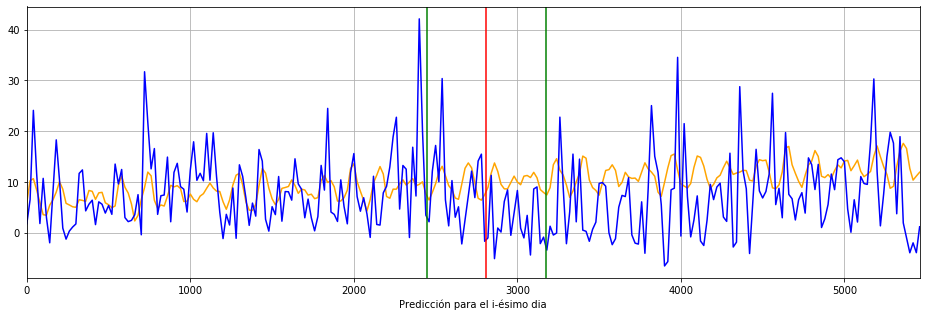

In [109]:
#df.plot(x="date", y=["DepDelay", "dl_pred"], figsize=(16,5))

def plot_df(df1, df2, train_limit_axis, unit_str):
    plt.figure(figsize=(16,5))
    plt.xlabel('Predicción para el i-ésimo {}'.format(unit_str))

    df2 = df2[df2.index % 20 == 0] 
    df1 = df1[df1.index % 20 == 0]
    ax1 = df1.dl_pred.plot(color='orange', grid=True, label='pred delay')
    df2.ArrDelay.plot(color='blue', grid=True, secondary_y=False, label='real delay', ax=ax1)

    xticks = ax1.xaxis.get_major_ticks()
    plt.axvline(x=train_limit_axis, color="green")
    plt.axvline(x=days_before_nine_eleven, color="red")
    plt.axvline(x=days_after_nine_eleven, color="green")
    
    plt.show()

df_full = pd.read_csv(tmp_dir+"daily/full.csv")
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
plot_df(df, df_full, len(train_delays), "dia")
plot_df(df, df, len(train_delays), "dia")

In [110]:
from sklearn.metrics import mean_squared_error

pre_error = math.sqrt(
    mean_squared_error(
        df.loc[(df["date"].dt.date < nine_eleven_event) & 
               (df["date"].dt.date >= year_before)]
        .dl_pred, 
        df_full.loc[(df_full["date"].dt.date < nine_eleven_event) & 
                    (df_full["date"].dt.date >= year_before)]
        .ArrDelay
    )
)

post_error = math.sqrt(
    mean_squared_error(
        df.loc[(df["date"].dt.date > nine_eleven_event) & 
               (df["date"].dt.date <= year_after)]
        .dl_pred, 
        df_full.loc[(df_full["date"].dt.date > nine_eleven_event) & 
                    (df_full["date"].dt.date <= year_after)]
        .ArrDelay
    )
)

print("Error tras 9/11: {} \nError antes de 9/11: {}".format(post_error, pre_error))

Error tras 9/11: 9.984517368656974 
Error antes de 9/11: 7.253953084497666


In [111]:
avg_before = df_full.loc[(df["date"].dt.date < nine_eleven_event) & 
       (df["date"].dt.date >= year_before)].mean()

avg_after = df_full.loc[(df_full["date"].dt.date > nine_eleven_event) & 
            (df_full["date"].dt.date <= year_after)].mean()

print("Diferencia de un año:")
print("*Promedio de delay de arribos antes del 9/11: {} \n*Promedio de delay después: {}".format(float(avg_before), float(avg_after)))

two_years_before =  nine_eleven_event - pd.offsets.DateOffset(years=2)
two_years_after =  nine_eleven_event + pd.offsets.DateOffset(years=2)

avg_before = df_full.loc[(df["date"].dt.date < nine_eleven_event) & 
       (df["date"].dt.date >= two_years_before)].mean()

avg_after = df_full.loc[(df_full["date"].dt.date > nine_eleven_event) & 
            (df_full["date"].dt.date <= two_years_after)].mean()
print("Diferencia de dos años:")
print("*Promedio de delay de arribos antes del 9/11: {} \n*Promedio de delay después: {}".format(float(avg_before), float(avg_after)))

Diferencia de un año:
*Promedio de delay de arribos antes del 9/11: 7.8320232977013555 
*Promedio de delay después: 3.2193421877035377
Diferencia de dos años:
*Promedio de delay de arribos antes del 9/11: 8.344831239587624 
*Promedio de delay después: 3.154037992231786


## Mensual

In [112]:
del df
df = pd.read_csv(tmp_dir+"monthly/full.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
train_delays = df.loc[df["date"].dt.date < year_before]["ArrDelay"]

days_before_nine_eleven = len(df.loc[df["date"].dt.date < nine_eleven_event])
days_after_nine_eleven = len(df.loc[df["date"].dt.date < year_after])

lpr = lsqPredictor(phases, monthly_freqs, max_grade)
lpr.fit(train_delays)
lpr.print_coefs()

Coef de x^0:
6.402026076243359
Coef de x^1:
0.036953043939272796
Coef de sinusoide con frecuencia 3 y fase 0.0:
12.191374794516522
Coef de sinusoide con frecuencia 3 y fase 1.5707963267948966:
-55.59982809471978
Coef de sinusoide con frecuencia 3 y fase 3.141592653589793:
12.666653306556876
Coef de sinusoide con frecuencia 3 y fase 4.71238898038469:
-55.970186335403724
Coef de sinusoide con frecuencia 4 y fase 0.0:
-735.1739902963175
Coef de sinusoide con frecuencia 4 y fase 1.5707963267948966:
-19.542861396593658
Coef de sinusoide con frecuencia 4 y fase 3.141592653589793:
-735.0774460411081
Coef de sinusoide con frecuencia 4 y fase 4.71238898038469:
-19.500733452104676
Coef de sinusoide con frecuencia 6 y fase 0.0:
-2.008716801403313
Coef de sinusoide con frecuencia 6 y fase 1.5707963267948966:
36.55787330463024
Coef de sinusoide con frecuencia 6 y fase 3.141592653589793:
-1.1601208459214507
Coef de sinusoide con frecuencia 6 y fase 4.71238898038469:
34.03021148036254
Coef de sinusoi

In [113]:
if "dl_pred" in df:
    del df["dl_pred"]

In [114]:
train_test_delays = df["ArrDelay"]

df["dl_pred"] = lpr.pred(train_test_delays) 

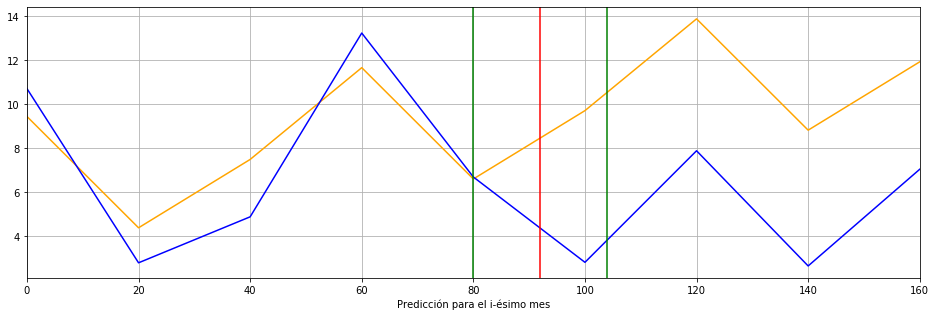

In [115]:
df_full = pd.read_csv(tmp_dir+"monthly/full.csv")
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
plot_df(df, df_full, len(train_delays), "mes")

In [116]:
pre_error = math.sqrt(
    mean_squared_error(
        df.loc[(df["date"].dt.date < nine_eleven_event) & 
               (df["date"].dt.date >= year_before)]
        .dl_pred, 
        df_full.loc[(df_full["date"].dt.date < nine_eleven_event) & 
                    (df_full["date"].dt.date >= year_before)]
        .ArrDelay
    )
)

post_error = math.sqrt(
    mean_squared_error(
        df.loc[(df["date"].dt.date > nine_eleven_event) & 
               (df["date"].dt.date <= year_after)]
        .dl_pred, 
        df_full.loc[(df_full["date"].dt.date > nine_eleven_event) & 
                    (df_full["date"].dt.date <= year_after)]
        .ArrDelay
    )
)

print("Error tras 9/11: {} \nError antes de 9/11: {}".format(post_error, pre_error))

Error tras 9/11: 6.9128567123541105 
Error antes de 9/11: 3.6407741913978042


In [117]:
avg_before = df_full.loc[(df["date"].dt.date < nine_eleven_event) & 
       (df["date"].dt.date >= year_before)].mean()

avg_after = df_full.loc[(df_full["date"].dt.date > nine_eleven_event) & 
            (df_full["date"].dt.date <= year_after)].mean()

print("Diferencia de un año:")
print("*Promedio de delay de arribos antes del 9/11: {} \n*Promedio de delay después: {}".format(float(avg_before), float(avg_after)))

two_years_before =  nine_eleven_event - pd.offsets.DateOffset(years=2)
two_years_after =  nine_eleven_event + pd.offsets.DateOffset(years=2)

avg_before = df_full.loc[(df["date"].dt.date < nine_eleven_event) & 
       (df["date"].dt.date >= two_years_before)].mean()

avg_after = df_full.loc[(df_full["date"].dt.date > nine_eleven_event) & 
            (df_full["date"].dt.date <= two_years_after)].mean()
print("Diferencia de dos años:")
print("*Promedio de delay de arribos antes del 9/11: {} \n*Promedio de delay después: {}".format(float(avg_before), float(avg_after)))

Diferencia de un año:
*Promedio de delay de arribos antes del 9/11: 7.9458172081584815 
*Promedio de delay después: 3.289541826360997
Diferencia de dos años:
*Promedio de delay de arribos antes del 9/11: 8.393617791051478 
*Promedio de delay después: 3.1574971284144593
